## Object Oriented Probability Model

In [1]:
from graphviz import Digraph
import pyro
import torch
pyro.set_rng_seed(101)

import pyro.distributions as dist
from pyro.infer import Importance, EmpiricalMarginal
import matplotlib.pyplot as plt

import numpy as np
from collections import Counter
from googlesearch import search
from ipywidgets import interactive
from IPython.display import display
from PIL import Image, ImageDraw, ImageFont
import os

### DAG

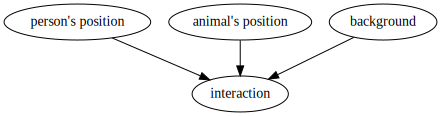

In [2]:
dag = Digraph(comment='DAG')
dag.node('P','person\'s position')
dag.node('Q','animal\'s position')
dag.node('B','background')
dag.node('I','interaction')
dag.edges(['PI', 'QI', 'BI'])
dag

#### pre-defined probabality distribution

In [3]:
alias = {'position1':['left','right'], 
         'position2':['left','right'], 
         'haircolor':['black', 'brown', 'golden'],
         'hairlength':['short','long'],
         'gender':['male','female'],
         'age':['young','old'],
         'color':['black', 'grey', 'brown'],
         'size':['little','large'],
         'type':['cat','dog'],
         'background':['in the park','at home'],
         'interaction':['fights','chases','calls','holds']
        }

prob = {'position1':torch.tensor([0.5,0.5]), 
        'position2':torch.tensor([0.5,0.5]), 
        'haircolor':torch.tensor([1/3, 1/3, 1/3]),
        'hairlength':torch.tensor([0.5,0.5]),
        'gender':torch.tensor([0.5,0.5]),
        'age':torch.tensor([0.5,0.5]),
        'color':torch.tensor([1/3,1/3,1/3]),
        'size':torch.tensor([0.5,0.5]),
        'type':torch.tensor([0.5,0.5]),
        'background':torch.tensor([0.5,0.5]),
        'interaction':torch.tensor([[[[0.97,0.01,0.01,0.01],[0.01,0.49,0.49,0.01]], #park: e1=left, [e2=left. e2=right]
                                     [[0.01,0.49,0.49,0.01],[0.97,0.01,0.01,0.01]]], #park:e1=right, [e2=left. e2=right]
                                    [[[0.49,0.01,0.01,0.49],[0.01,0.01,0.97,0.01]], #home: e1=left, [e2=left. e2=right]
                                     [[0.01,0.01,0.97,0.01],[0.49,0.01,0.01,0.49]]]]) #home: e1=right, [e2=left. e2=right]
       }
causal_var = ['position1', 'position2', 'background', 'interaction']
other_var = ['haircolor', 'hairlength', 'gender', 'age', 'color', 'size', 'type']
infer_var = ['interaction', 'background']

In [4]:
class Person(object):
    def __init__(self):
        self.position1 = pyro.sample("position1", dist.Categorical(probs=prob['position1'])) 
        self.haircolor = pyro.sample("haircolor", dist.Categorical(probs=prob['haircolor']))
        self.hairlength = pyro.sample("hairlength", dist.Categorical(probs=prob['hairlength']))
        self.gender = pyro.sample("gender", dist.Categorical(probs=prob['gender']))
        self.age = pyro.sample("age", dist.Categorical(probs=prob['age']))
        
class Animal(object):
    def __init__(self):
        self.position2 = pyro.sample('position2', dist.Categorical(prob['position2']))
        self.color = pyro.sample('color', dist.Categorical(prob['color']))
        self.size = pyro.sample('size', dist.Categorical(prob['size']))
        self.type = pyro.sample('type', dist.Categorical(prob['type']))
        
class Background(object):
    def __init__(self):
        self.background = pyro.sample('background', dist.Categorical(prob['background']))
        
class Interaction(object):
    def __init__(self, entity1, entity2, background):
        self.interaction = pyro.sample('interaction', dist.Categorical(prob['interaction'][background.background][entity1.position1][entity2.position2]))

In [5]:
def model():
    person = Person()
    animal = Animal()
    background = Background()
    interaction = Interaction(person, animal, background)
    
def condition(model, evidence, num_samples = 1000):
    condition_model = pyro.condition(model, data=evidence)
    posterior = pyro.infer.Importance(condition_model, num_samples=num_samples).run()
    return posterior

def intervention(model, evidence, num_samples = 1000):
    do_model = pyro.do(model, data=evidence)
    posterior = pyro.infer.Importance(do_model, num_samples=num_samples).run()
    return posterior

def pltDistribution(posterior, infer, num_samples = 1000):
    for i in range(len(infer)):
        marginal = EmpiricalMarginal(posterior, infer[i])
        samples = [marginal().item() for _ in range(num_samples)]
        unique, counts = np.unique(samples, return_counts=True)
        plt.figure(i)
        plt.bar(unique, counts / num_samples, align='center')
        plt.xticks(unique, alias[infer[i]])
        plt.ylabel('prob')
        plt.xlabel(infer[i])
        
def mostOccurance(posterior, infer, num_samples = 1000):
    sample = []
    for i in range(num_samples): 
        trace = posterior()
        value = []
        for i in range(len(infer)):
            value.append(trace.nodes[infer[i]]['value'])
        sample.append(tuple(value))

    most_common, num_most_common = Counter(sample).most_common(1)[0]
    
    infer_dict = {}
    for i in range(len(infer)):
        infer_dict[infer[i]] = most_common[i]
    return infer_dict

def getLabel(infer_res):
    for key in infer_res:
        infer_res[key] = alias[key][infer_res[key]]
    return infer_res

In [6]:
def getVar(w):
    do_var = w.kwargs
    do_causal_var = {}
    do_other_var = {}
    for var in causal_var:
        if do_var[var] == '-':
            continue
        else:
            do_causal_var[var] = torch.tensor(alias[var].index(do_var[var]))
    for var in other_var:
        if do_var[var] == '-':
            continue
        else:
            do_other_var[var] = torch.tensor(alias[var].index(do_var[var]))
    return do_causal_var, do_other_var

def getInfer(do_causal_var):
    infer_all = infer_var.copy()
    do_causal_var_key = list(do_causal_var.keys())
    for var in do_causal_var_key:
        if var in infer_all:
            infer_all.remove(var)
    return infer_all

def getEntity(input_dic):
    dic = {}
    person = Person()
    animal = Animal()
    background = Background()
    interaction = Interaction(person,animal,background)
    entity_list = [person,animal,background,interaction]
    for k in entity_list:
        entity_dic = k.__dict__
        dic.update(entity_dic)
        
    for k in dic:
        dic[k] = alias[k][dic[k]]
    dic.update(input_dic)
    return dic

def getScene(input_dict):
    scene = str("A %s %s with %s %s hair %s a %s %s %s %s." % 
                (input_dict['age'],input_dict['gender'],input_dict['haircolor'],input_dict['hairlength'],
                 input_dict['interaction'],input_dict['size'],input_dict['color'],input_dict['type'],
                 input_dict['background']))
    print(scene)
    return scene

In [7]:
def userInterface():
    def f_interactive(position1,position2,haircolor,hairlength,gender,age,color,size,type,background,interaction):
        pass

    w = interactive(f_interactive, 
                       position1=sum([["-"],alias['position1']], []),
                       position2=sum([["-"],alias['position2']], []),
                       haircolor=sum([["-"],alias['haircolor']], []),
                       hairlength=sum([["-"],alias['hairlength']], []),
                       gender=sum([["-"],alias['gender']], []),
                       age=sum([["-"],alias['age']], []),
                       color=sum([["-"],alias['color']], []),
                       size=sum([["-"],alias['size']], []),
                       type=sum([["-"],alias['type']], []),
                       background=sum([["-"],alias['background']], []),
                       interaction=sum([["-"],alias['interaction']], []))
    return w

In [8]:
class generatePic(object):
    '''
    This class takes generated features from causal OOP model and implements it into a picture.
    '''
    def __init__(self, attr_dict, scene):
        self.position1 = attr_dict['position1']
        self.position2 = attr_dict['position2']
        self.haircolor = attr_dict['haircolor']
        self.hairlength = attr_dict['hairlength']
        self.gender = attr_dict['gender']
        self.age = attr_dict['age']
        self.type = attr_dict['type']
        self.size = attr_dict['size']
        self.color = attr_dict['color']
        self.background = attr_dict['background']
        self.scene = scene
        self.personImage, self.animalImage, self.backgroundImage = self.getImage()
        self.finalImage = self.getFinalImage()
        
    def getImage(self):
        '''
        load raw pictures as elements from local directory
        '''
        try:
            im_g = Image.open("./pic/"+self.gender+".png")
        except:
            im_g = Image.open("./pic/"+self.gender+".jpg")
        try:
            im_t = Image.open("./pic/"+self.type+".png")
        except:
            im_t = Image.open("./pic/"+self.type+".jpg")
        try:
            im_b = Image.open("./pic/"+self.background+".png")
        except:
            im_b = Image.open("./pic/"+self.background+".jpg")
        return im_g, im_t,im_b
            
    def hair(self):
        color_dict = {'golden':(255, 204, 0), 'black':'black', 'brown':(115, 77, 38)}
        fix_w = int(self.personImage.width/10)
        fix_h = int(self.personImage.height/6) if self.hairlength == 'short' else int(self.personImage.height/3)    
        for i in range(30):
            img1 = ImageDraw.Draw(self.personImage)
            shape = [(int(self.personImage.width/2)-20+i,int(self.personImage.height/20)),(fix_w,fix_h)]
            if i not in range(10,20):
                img1.line(shape,fill =color_dict[self.haircolor],width=2) 
            fix_w += 10

    def ages(self):
        if self.age == 'old':
            fix_w = int(self.personImage.width/2)
            fix_h = int(self.personImage.height/18)
            for i in range(4):
                img1 = ImageDraw.Draw(self.personImage)
                shape = [(fix_w-5*i,fix_h),(fix_w+5*i,fix_h)]
                img1.line(shape,fill ="white") 
                fix_h+=7
    
    def animal_color(self):
        color = self.color
        rgb_dict = {'black': (0, 0, 0),
                   'grey': (165, 169, 176),
                   'brown': (179, 120, 61)}
        self.animalImage = self.animalImage.convert('RGBA')
        data = np.array(self.animalImage)
        red, green, blue, alpha = data.T

        white_areas = (red == 255) & (blue == 255) & (green == 255)
        data[..., :-1][~white_areas.T] = rgb_dict[color]

        self.animalImage = Image.fromarray(data)
        
    def getSize(self):
        if self.size == 'little':
            rt = [0.08, 0.16]
        else:
            rt = [0.15, 0.3]
        return rt
    
    def resize_pic(self, entityImage, rt = [0.25,0.5]):
        '''
        resize entities' (person's and animal's) pictures to adjust the background
        '''
        maxwidth, maxheight = self.backgroundImage.width*rt[0], self.backgroundImage.height*rt[1]
        if entityImage.width>=maxwidth:
            new_w = int(maxwidth)
            ratio = entityImage.height/entityImage.width
            new_h = int(new_w*ratio)
        if entityImage.height>=maxheight:
            new_h = int(maxheight)
            ratio = entityImage.height/entityImage.width
            new_w = int(new_h/ratio)
        entityImage_new = entityImage.resize((new_w,new_h))
        return entityImage_new      
    
    def get_concat(self, color=(255,255,255)):
        '''
        combine person's, animal's and background's picture into one picture
        '''
        if self.position1 == self.position2:
            dis = 0
        else:
            dis = 500
        image = Image.new('RGBA', self.backgroundImage.size ,color)
        image.paste(self.backgroundImage,(0,0))
        if self.position1 == 'right' and self.position2 == 'left':
            leftImage = self.animalImage
            rightImage = self.personImage
        else:
            leftImage = self.personImage
            rightImage = self.animalImage
        image.paste(leftImage, (int((self.backgroundImage.width-dis)/2-leftImage.width), self.backgroundImage.height-leftImage.height))
        image.paste(rightImage, (int((self.backgroundImage.width+dis)/2), self.backgroundImage.height-rightImage.height))
        return image
    
    def addDescription(self,image):
        l = ImageDraw.Draw(image)
        font = ImageFont.truetype('arial.ttf', size=32);
        l.text((50, 50), self.scene, font = font, align ="center")  
        
    def getFinalImage(self):
        self.hair()
        self.ages()
        self.animal_color()
        self.personImage = self.resize_pic(self.personImage, rt = [0.25,0.5])
        self.animalImage = self.resize_pic(self.animalImage, rt = self.getSize())
        image = self.get_concat()
        self.addDescription(image)
        return image
        
    def draw(self):
        self.finalImage.show()

In [9]:
def model_condition(w, plot = False):
    do_causal_var, do_other_var = getVar(w)
    infer = getInfer(do_causal_var)
    infer_model = condition(model, evidence = do_causal_var)
    do_causal_var.update(do_other_var)
    infer_res = {}
    if infer:
        if plot:
            pltDistribution(infer_model, infer)
        infer_res = mostOccurance(infer_model, infer)
    infer_res.update(do_causal_var)
    infer_res = getLabel(infer_res)
    final_dict = getEntity(infer_res)
    scene = getScene(final_dict)
    return final_dict, scene

In [10]:
def model_intervention(w, plot = False):
    do_causal_var, do_other_var = getVar(w)
    infer = getInfer(do_causal_var)
    infer_model = intervention(model, evidence = do_causal_var)
    do_causal_var.update(do_other_var)
    infer_res = {}
    if infer:
        if plot:
            pltDistribution(infer_model, infer)
        infer_res = mostOccurance(infer_model, infer)
    infer_res.update(do_causal_var)
    infer_res = getLabel(infer_res)
    final_dict = getEntity(infer_res)
    scene = getScene(final_dict)
    return final_dict, scene

In [11]:
w = userInterface()
display(w)

interactive(children=(Dropdown(description='position1', options=('-', 'left', 'right'), value='-'), Dropdown(d…

A young male with brown short hair fights a little brown dog at home.


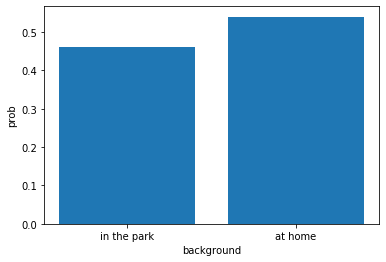

In [12]:
final_dict, scene = model_condition(w, True)
pic = generatePic(final_dict, scene)
pic.draw()

A young female with brown long hair fights a little brown dog in the park.


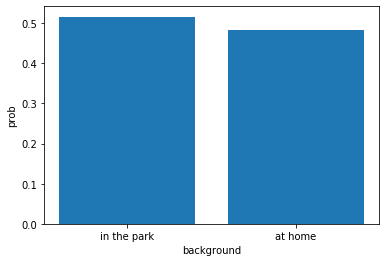

In [13]:
final_dict, scene = model_intervention(w, plot = True)
pic = generatePic(final_dict, scene)
pic.draw()